In [1]:
# the purpose of this notebook is to test the performance of our final attempt at an analytical solution:
# a case with plucking and sediment transport
# but no bedrock abrasion or grain attrition
# full derivation is below

Start with conservation of mass of sediment in a landscape "cell":
> $$\frac{\partial M}{\partial t} = \text{Mass in} - \text{Mass out}$$

The cell has height $H$, total width $B$, and length $dx$. Contained within the cell is a of channel width $b$. The sediment has porosity $\phi$ and density $\rho$. The cell is experiencing uniform uplift $U$. Mass is added via sediment flux into the cell, and generation of sediment within the cell via bedrock plucking. Plucking is a function of the fraction of bed cover, $\alpha$; sediment flux also depends on this quantity. Mass is lost via sediment flux out of the cell. Putting all these pieces together, we arrive at:
> $$\frac{\partial H B dx (1-\phi) \rho}{\partial t} = Q_s\bigr\rvert_{x} \rho + K\frac{Q}{B}S^{7/6}\alpha B dx \rho - Q_s\bigr\rvert_{x + \Delta x} \rho$$

We can remove the constants from the partial derivative and bring them to the RHS of the equation:
> $$\frac{\partial H}{\partial t} = \frac{Q_s\bigr\rvert_{x} \rho}{B dx (1-\phi) \rho} + \frac{K Q S^{7/6} \alpha B dx \rho}{B B dx (1-\phi) \rho} - \frac{Q_s\bigr\rvert_{x + \Delta x} \rho}{B dx (1-\phi) \rho}$$

Simplify, pull out the constant denominator:
> $$\frac{\partial H}{\partial t} = \frac{1}{(1-\phi)B} \left(\frac{Q_s\bigr\rvert_{x}}{dx} + K Q S^{7/6} \alpha - \frac{Q_s\bigr\rvert_{x + \Delta x}}{dx}\right)$$

Pull out -1, rearrange, and rewrite sediment flux pieces as a derivative:
> $$\frac{\partial H}{\partial t} = -\frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} - K Q S^{7/6} \alpha\right)$$

Set $dH/dt$ equal to 0, and go about solving for slope:
> $$0 = -\frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} - K Q S^{7/6} \alpha\right)$$

> $$\frac{1}{(1 - \phi)B}\frac{\partial Q_s}{\partial x} = \frac{K Q S^{7/6} \alpha}{(1-\phi)B}$$

> $$\frac{\partial Q_s}{\partial x} = K Q S^{7/6} \alpha$$

At steady state, uplift = erosion, meaning uplift rate = plucking rate. We can write this as:

> $$U = K \frac{Q}{B} S^{7/6} \alpha$$

We can rearrange this to solve for $\alpha$:

> $$\alpha = \frac{UB}{KQS^{7/6}}$$

This can be plugged into the equation for sediment flux above, giving us:

> $$\frac{\partial Q_s}{\partial x} = UB$$

Now we continue working towards isolating slope, which lives in the equation for $Q_s$:

> $$d Q_s = UB  dx$$

Replace B with $ax^{1/5}$ and integrate both sides:

> $$\int_{0}^{Q_s} d Q_s = U a \int_{0}^{x} x^{1/5} dx$$

Solve the integral:

> $$Q_s = \frac{5}{6} U a x^{6/5}$$

Rewrite $Q_s$:

> $$k_{qs}IQS^{7/6}(1 - \alpha) = \frac{5}{6} U a x^{6/5}$$

Replace $\alpha$ with equation from above:

> $$k_{qs}IQS^{7/6}(1 - \frac{UB}{KQS^{7/6}}) = \frac{5}{6} U a x^{6/5}$$

Distribute:

> $$k_{qs}IQS^{7/6} - \frac{k_{qs}IQS^{7/6}UB}{KQS^{7/6}} = \frac{5}{6} U a x^{6/5}$$

Simplify and eliminate the denominator:

> $$k_{qs}IQS^{7/6}K - k_{qs}IUB = \frac{5}{6} U a x^{6/5}K$$

Pull out common factors:

> $$k_{qs}I (QS^{7/6}K - UB) = \frac{5}{6} U a x^{6/5}K$$

Go about solving for $S$:

> $$QS^{7/6}K - UB = \frac{5}{6} \frac{U a x^{6/5}K}{k_{qs}I}$$

> $$QS^{7/6}K = \frac{5}{6} \frac{U a x^{6/5}K}{k_{qs}I} + UB$$

> $$S^{7/6} = \frac{5}{6} \frac{U a x^{6/5} K}{k_{qs} I Q K } + \frac{UB}{QK}$$

Replace $B$ with $ax^{1/5}$ and $Q$ with $\frac{5}{6}rax^{6/5}$:

> $$S^{7/6} = \frac{5}{6} \frac{6}{5} \frac{U a x^{6/5} K}{k_{qs} I S_0 r a x^{6/5} K } + \frac{6}{5} \frac{U ax^{1/5}}{r a x^{6/5} K}$$

Simplify:

> $$S^{7/6} = \frac{U}{k_{qs} I r} + \frac{6}{5} \frac{U}{r x K}$$

> $$\boxed{S = \left(\frac{U}{k_{qs} I r} + \frac{6}{5} \frac{U}{r x K}\right)^{6/7}}$$

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define parameters

dx = 1000 # grid spacing
x = np.arange(0, 10000, dx) # domain length
x_node = x + dx/2

baselevel_rate = 0.0001 # uplift rate
phi = 0.0 ##0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
S0 = 0.15 # slope linearizer
##K = 0.1 # erodibility
K = 1.5e-8 ##
# K[:3] = 0.000001
# K[3:] = 0.00001
Hstar = 0.5
a = 25 # valley width coeffecient (kxb, in wickert & schildgen)
Pxb = (1/5) # valley width exponent

In [4]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [5]:
# calculate constant, derivative values

B = a * (x_node**Pxb) # valley width   ## TWEAKED
Q = (r * a * x**(1 + Pxb))/(1 + Pxb) # discharge  ## WE TWEAKED THIS

In [9]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          kqs,
          I,
          K,
          a,
          Pxb,
          phi,
          baselevel_rate,
          Q,
          B,
          num_steps = 5000000):
    
    dx = 1000 # grid spacing
    x = np.arange(0, 10000, dx) # domain length
    x_node = x + dx/2
        
    # calculate timestep
    dt = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1])))
    
    # define arrays
    Eb_unit = np.zeros(len(x)) # bedrock erosion rate
    Eb_total = np.zeros(len(x)) # total bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    Qs = np.zeros(len(x)) # total sediment transport
    
    # set boundary conditions
    #H[-1] = 0
    E[-1] = 0 # also try baselevel_rate
    Qs[0] = 0
    
    for i in range(num_steps):
            
        # calculate slope
        S = np.abs(np.diff(eta)/dx)
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T)
        Qs[1:] = kqs * I * Q[1:] * (S** (7./6.)) * (1-alpha[:-1])
        
        # calculate bedrock erosion rate (plucking) (L^2/T)
        Eb_total[:-1] = (K * Q[1:] * S**(7./6.) * alpha[:-1]) ##/phi
        
        # total bedrock erosion (L/T)
        Eb_unit = Eb_total / B
       
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/((1 - phi) * B[1:])) * ((np.diff(Qs)/dx) - Eb_total[:-1])
        
        # calculate total erosion rate (L/T)
        E[:-1] = Eb_unit[:-1] + Eh[:-1]
        
        # update boundary conditions
        eta[-1] -= baselevel_rate * dt
        etab[-1] = eta[-1]
        
        # update topography
        etab[:-1] -= Eb_unit[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]

        
    return (S, alpha, Qs, Eb_total, Eb_unit, Eh, E, eta, etab, H, dt)

In [10]:
# now write a test
test = [dx, x, Hstar, H, etab, eta, kqs, I, K, a, Pxb, phi, baselevel_rate, Q, B]

# and run it
S, alpha, Qs, Eb_total, Eb_unit, Eh, E, eta, etab, H, dt = model(*test)

In [11]:
E

array([9.98764615e-05, 9.99686822e-05, 9.99839757e-05, 9.99903318e-05,
       9.99938144e-05, 9.99960041e-05, 9.99974989e-05, 9.99985763e-05,
       9.99993830e-05, 0.00000000e+00])

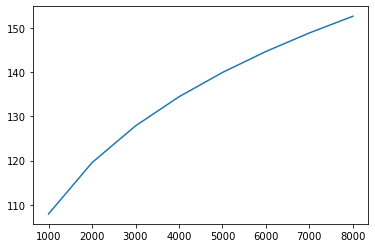

In [32]:
plt.plot(x[1:-1], Eb_total[1:-1]/E[1:-1])

In [12]:
# now calc slopes analytically
# slope_prediction = ((baselevel_rate)/(kqs * I * r)) + ((6 * baselevel_rate)/(5 * r * x[1:] * K))**(6./7.)
# slope_prediction = (baselevel_rate / (kqs * I * r) + 6.0 * baselevel_rate / (5.0 * K * r * x[1:]))**(6./7.)
slope_prediction = ((baselevel_rate / (kqs * I * r)) + (6.0 * baselevel_rate) / (5.0 * K * r * x[1:]))**(6./7.)

In [13]:
print('slope prediction: ', slope_prediction)
print('modeled slopes: ', S)

slope prediction:  [0.84744957 0.47966912 0.34717824 0.27779069 0.23476455 0.20534438
 0.18389606 0.16753385 0.15462202]
modeled slopes:  [0.75551789 0.45828985 0.33767353 0.27240926 0.23129934 0.20292676
 0.18211423 0.16616711 0.15354137]


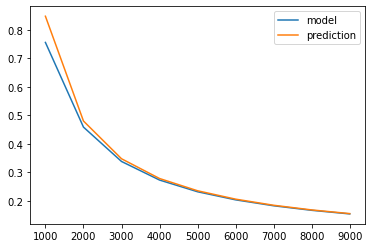

In [14]:
plt.plot(x[1:], S, label = 'model')
plt.plot(x[1:], slope_prediction, label = 'prediction')
plt.legend()

In [15]:
predicted_topo = -(slope_prediction * x[1:])

baselevel_difference = eta[-1] - predicted_topo[-1]

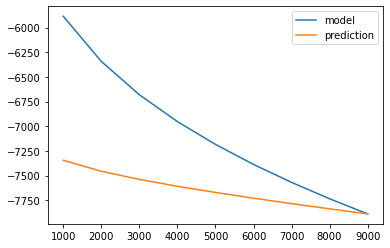

In [16]:
plt.plot(x[1:], eta[1:], label = 'model')
plt.plot(x[1:], predicted_topo + baselevel_difference, label = 'prediction')
plt.legend()

GT scribbles below here...

The bedrock erosion rate should equal the uplift rate:

In [ ]:
U = 0.0001

In [ ]:
print(U)
print(Eb_unit[0])

CHECK.

At the top node, alpha should be:

$$\alpha = \frac{UB}{KQS^{7/6}}$$

In [ ]:
print(U * B[0]/ (K * Q[1] * S[0]**(7./6.)))
print(alpha[0])

CHECK.

Soil thickness should then be:

In [ ]:
print(-Hstar * np.log(U * B[0] / (K * Q[1] * S[0]**(7./6.))))
print(H[0])

CHECK.

Sediment flux out of the top node should be $k_q I Q S^{7/6} (1 - \alpha )$: 

In [ ]:
print(kqs * I * Q[1] * S[0]**(7./6.) * (1 - alpha[0]))
print(Qs[1])

CHECK.

Given all this, input rate must equal output rate at the top node (per unit area):

$$in = K Q S^{7/6} \alpha / B$$

$$out = kqs I Q S^{7/6} (1-\alpha) / B \Delta x$$



In [ ]:
print(K * Q[1] * S[0]**(7./6.) * alpha[0] / B[0])
print(kqs * I * Q[1] * S[0]**(7./6.) * (1.0 - alpha[0]) / (B[0] * dx))

The slope at the top node should then be:

$$S(0) = \left(\frac{UB\Delta x}{k_Q I Q} + \frac{UB}{KQ}\right)^{6/7}$$

In [ ]:
print((U * B[0] * dx / (kqs * I * Q[1]) + U * B[0] / (K * Q[1]))**(6./7.))
print(S[0])

How does this compare with the more general analytical prediction?

$$S(0) = \left(\frac{U}{k_Q I r} + \frac{UB}{KQ}\right)^{6/7}$$

In [ ]:
print((U / (kqs * I * r) + U * B[0] / (K * Q[1]))**(6./7.))
print(S[0])

That's pretty darn close. Shouldn't be exactly the same, because the numerics give $r \approx Q / B \Delta x$. But still, why does this form of the math work when the other form does not seem to?

Let's take it one step further: swap in the expression for $B$:

$$S(0) = \left(\frac{U}{k_Q I r} + \frac{Uax^{1/5}}{KQ}\right)^{6/7}$$

In [ ]:
print((U / (kqs * I * r) + U * a * x_node[0]**0.2 / (K * Q[1]))**(6./7.))
print(S[0])

Now how about $Q$? First, just test that bit:

In [ ]:
print((5./6.) * a * x_node[0]**(6./5.))
print(Q[1])

Ok, that reminds us that $Q$ is evaluated at node interfaces, not centers:

In [ ]:
print((5./6.) * r * a * x[1]**(6./5.))
print(Q[1])

So then if we put in that substitution, in theory the math should still work:

$$S(0) = \left(\frac{U}{k_Q I r} + \frac{6U}{5Krx}\right)^{6/7}$$

In [ ]:
print((U / (kqs * I * r) + 6.0 * U / (5.0 * K * r * x_node[0]))**(6./7.))
print(S[0])

Not quite right, but let's suppose we use the edge-based $x$, since that is what is used to evaluate $Q$:

In [ ]:
print((U / (kqs * I * r) + 6.0 * U / (5.0 * K * r * x[1]))**(6./7.))
print(S[0])

There it is!!

More generally, let's evaluate the whole thing this way:

In [ ]:
Spred = (U / (kqs * I * r) + 6.0 * U / (5.0 * K * r * x[1:]))**(6./7.)
print(Spred)
print(S)
plt.plot(S)
plt.plot(Spred)

The slight offset is probably just numerical (and it's in the 3rd decimal place).

So, it was just an issue of the half-node offset between node centers and node edges!